# PhD Summer School - HIPERWIND
# Performing HSIC-based sensitivity analysis using OpenTURNS

### Authors: J. Pelamatti, V. Chabridon, E. Fekhari

The wing weight function
========================

The wing weight function of *Forrester et al. (2008)* is a recurrent test case for modeling purpose and sensitivity analysis in aerospace context.

This function is extracted and adapted from the Raymer Handbook for Aircraft Design. It is representative of a Cessna C172 Skyhawk wing aircraft.

It depends various input variables: the wing area, the weight of fuel in the wing, the aspect ratio, the quarter-chord sweep angle, the dynamic pressure at cruise,
the taper ratio, the airfoil thickness to chord ratio, the ultimate load factor, the flight design gross weight and the paint weight.


![Plane!](figures/wingweight.png "Plane")


The function is defined as follows:

$g(S_{w},W_{fw},A, \Lambda, q, \ell, t_c, N_z, W_{dg}, W_p) = 0.036 S_w^{0.758} {W_{fw}}^{0.0035}\left(\frac{A}{\cos^2(\Lambda)}\right)^{0.6} q^{0.006}  \ell^{0.04} \left(\frac{100 t_c}{\cos(\Lambda)}\right)^{-0.3}(N_z W_{dg})^{0.49}+S_w W_p$

with:

- $S_w \sim\mathcal{U}([150, 200])$, the wing area (ft^2)

- $W_{fw} \sim\mathcal{U}([220, 300])$,  the weight of fuel in the wing (lb)
		 
- $A \sim\mathcal{U}([6, 10])$, the aspect ratio (-)
		 
- $\Lambda \sim\mathcal{U}([-10, 10])$, the quarter-chord sweep angle (deg)
		 
- $q \sim\mathcal{U}([16, 45])$, the dynamic pressure at cruise (lb/ft^2)

- $\ell \sim\mathcal{U}([0.5, 1])$, the taper ratio (-)
		 
- $t_c \sim\mathcal{U}([0.08, 0.18])$, the airfoil thickness to chord ratio (-)
		 
- $N_z \sim\mathcal{U}([2.5, 6])$, the ultimate load factor (-)
		 
- $W_{dg} \sim\mathcal{U}([1700, 2500])$, the flight design gross weight (lb)

- $W_p \sim\mathcal{U}([0.025, 0.08])$, the paint weight (lb/ft^2)

We assume that the input variables are independent.


## 0 -- Import packages

In [54]:
%matplotlib inline

In [55]:
import openturns as ot
import openturns.viewer as otv
from openturns.usecases.wingweight_function import WingWeightModel
from matplotlib import pyplot as plt
import numpy as np

ot.Log.Show(ot.Log.NONE)

## 1 -- Definition of the model

We load the model from the usecases module.





In [56]:
## We now define our use case
m = WingWeightModel()

## The weight function can be extracted as
funct = m.model

## Similarly, the input distribution can be obtained as
dist = m.distributionX

## 2 -- Input-output data generation and visualization

We create the input and output data for the estimation of the different sensitivity coefficients and we get the input variables description:

In [57]:
## Get variables' names
inputNames = m.distributionX.getDescription()
print(inputNames)

## The elements of the generated sample are independent and identically distributed
sampleSize = 1000
inputDesign = m.distributionX.getSample(sampleSize)
outputDesign = m.model(inputDesign)

## Get input dimension
d = inputDesign.getDimension()

[Sw,Wfw,A,Lambda,q,l,tc,Nz,Wdg,Wp]#10


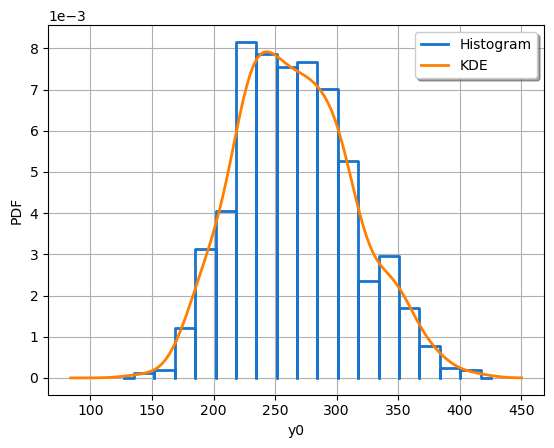

In [58]:
## Plot the output histogram
graph = ot.HistogramFactory().build(outputDesign).drawPDF()
kde = ot.KernelSmoothing()
fit = kde.build(outputDesign)
kde_curve = fit.drawPDF()
graph.add(kde_curve)
graph.setColors(["dodgerblue3", "darkorange1"])
graph.setLegends(["Histogram", "KDE"])
graph.setLegendPosition("topright")
graph.setTitle("")
view = otv.View(graph)

## 3 -- Performing a global sensitivity analysis (GSA)

### Estimation of HSIC indices

We then estimate the HSIC indices using a *given-data* approach.

In [59]:
## Since our input variables are real-valued random variables,
## one can define each kernel for each input variable as a squared exponential covariance model
covarianceModelCollection = []
for i in range(m.dim):
    Xi = inputDesign.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation()) # Empirical estimate of the standard deviation
    covarianceModelCollection.append(inputCovariance)

We now define and parametrize a covariance kernel associated to the output variable.

In [60]:
# Similarly, the output variable of interest is real-valued
outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(outputDesign.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

Then, we need to choose an estimator.

In [61]:
# Type of estimator can be either a U-stat or a V-stat.
estimatorType = ot.HSICUStat() # ot.HSICVStat()

Now, we can build an HSIC study using the components introduced above.

In [62]:
# Build a global sensitivity analysis (GSA) study
GSAstudy = ot.HSICEstimatorGlobalSensitivity(
    covarianceModelCollection,
    inputDesign, outputDesign,
    estimatorType
)

We get the R2-HSIC indices:



In [63]:
R2HSICIndices = GSAstudy.getR2HSICIndices()
print("(GSA study) R2-HSIC indices:\n", R2HSICIndices)

(GSA study) R2-HSIC indices:
 [0.0712507,-3.69571e-05,0.168594,-0.000551794,-8.23843e-05,0.00160909,0.0728002,0.32106,0.0305812,-0.000595565]#10


and the HSIC indices:



In [64]:
HSICIndices = GSAstudy.getHSICIndices()
print("(GSA study) HSIC Indices:\n", HSICIndices)

(GSA study) HSIC Indices:
 [0.00626601,-3.22213e-06,0.0147771,-4.86636e-05,-7.34061e-06,0.000141797,0.0063704,0.0283806,0.00265102,-5.31469e-05]#10


### Testing significance for screening

We can use first the asymptotic version of the test (i.e., based on the asymptotics of the test statistics).

In [65]:
pvalAsymp = GSAstudy.getPValuesAsymptotic()
print("p-values (asymptotic):\n", pvalAsymp)

p-values (asymptotic):
 [2.16703e-31,0.423328,6.76804e-70,0.578499,0.433746,0.125497,2.89531e-31,8.39964e-118,5.66635e-14,0.596649]#10


<span style="color:red">=> **Be careful: in general, we don't really know whether we are in the 'asymptotic regime' or not!**</span>

We can also use the permutation-based test which remains valid in a the non-asymptotic regime.

In [66]:
pvalPerm = GSAstudy.getPValuesPermutation()
print("p-values (permutation):\n", pvalPerm)

# Remark: we can set the number of permutations using:
# GSAstudy.setPermutationSize(B)

p-values (permutation):
 [0,0.386139,0,0.574257,0.465347,0.0693069,0,0,0,0.564356]#10


### Visualizing results

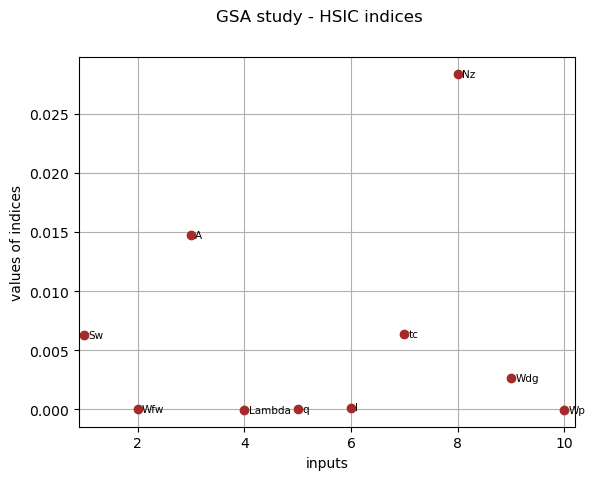

In [67]:
## Visualize HSIC indices
graph_GSA_HSICindices = GSAstudy.drawHSICIndices()
graph_GSA_HSICindices.setColors(["brown", "black"])
graph_GSA_HSICindices.setXTitle("inputs")
graph_GSA_HSICindices.setYTitle("values of indices")
graph_GSA_HSICindices.setTitle("GSA study - HSIC indices")
view = otv.View(graph_GSA_HSICindices)

<span style="color:blue">**=> Results' analysis: What do you see?**</span>

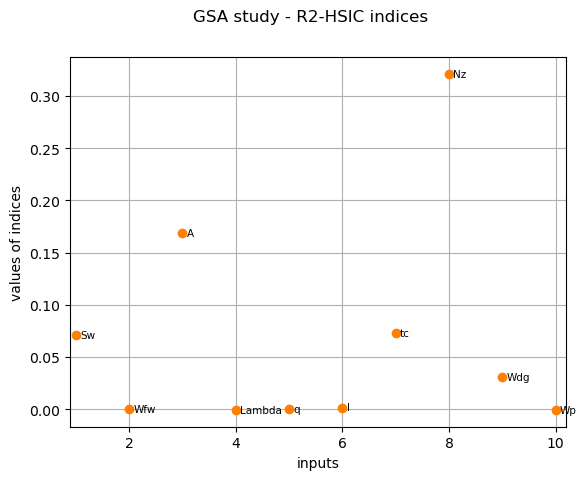

In [68]:
## Visualize R2-HSIC indices
graph_GSA_R2HSICIndices = GSAstudy.drawR2HSICIndices()
graph_GSA_R2HSICIndices.setColors(["darkorange1", "black"])
graph_GSA_R2HSICIndices.setXTitle("inputs")
graph_GSA_R2HSICIndices.setYTitle("values of indices")
graph_GSA_R2HSICIndices.setTitle("GSA study - R2-HSIC indices")
view = otv.View(graph_GSA_R2HSICIndices)

<span style="color:blue">**=> Results' analysis: What do you see?**</span>

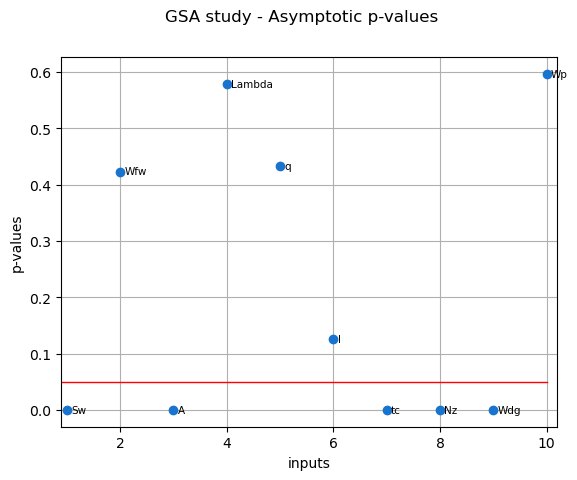

In [69]:
# Visualize asymptotic p-values
graph_GSA_pvalAsymp = GSAstudy.drawPValuesAsymptotic()
g = ot.SymbolicFunction("x","0.05") # Threshold 5%
threshold_pval = g.draw(0,d)
graph_GSA_pvalAsymp.add(threshold_pval)
graph_GSA_pvalAsymp.setColors(["dodgerblue3", "black", "red"])
graph_GSA_pvalAsymp.setXTitle("inputs")
graph_GSA_pvalAsymp.setYTitle("p-values")
graph_GSA_pvalAsymp.setTitle("GSA study - Asymptotic p-values")
view = otv.View(graph_GSA_pvalAsymp)

<span style="color:blue">**=> Results' analysis: What do you see?**</span>

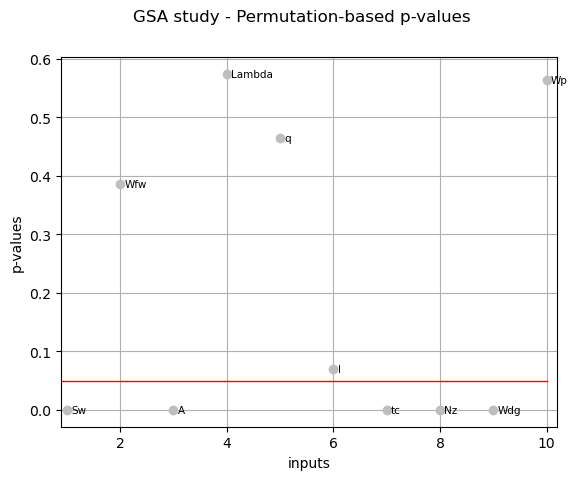

In [70]:
# Visualize permutation-based p-values
graph_GSA_pvalPerm = GSAstudy.drawPValuesPermutation()
g = ot.SymbolicFunction("x","0.05") # Threshold 5%
threshold_pval = g.draw(0,d)
graph_GSA_pvalPerm.add(threshold_pval)
graph_GSA_pvalPerm.setColors(["gray", "black", "red"])
graph_GSA_pvalPerm.setXTitle("inputs")
graph_GSA_pvalPerm.setYTitle("p-values")
graph_GSA_pvalPerm.setTitle("GSA study - Permutation-based p-values")
view = otv.View(graph_GSA_pvalPerm)

<span style="color:blue">**=> Results' analysis: What do you see?**</span>

<span style="color:green">**=> Global analysis:**</span>
If $\mathrm{p-value} < \alpha$ (here, $\alpha = 0.05$), $\mathcal{H}_0$ is rejected.

Thus, here, $\mathcal{H}_0$ (i.e., independence between $X_j$ and $Y$) is rejected for the variables $S_{w}, A, \ell, t_{c}, N_{z}, W_{dg}, W_{p}$.

## 4 -- Performing a target sensitivity analysis (TSA)

The standard HSIC indices allow to assess the influence of the input variables on the entire output distribution.

We now consider the **Target HSIC (T-HSIC) indices**, which characterize the influence of the input variables with respect to a critical domain of the output (typically, a threshold exceedance). 

### Defining the critical domain

We start by defining the *critical output domain* as $Y \in [350, \inf[$.

In [71]:
criticalThreshold = 350
criticalDomain = ot.Interval(criticalThreshold, float("inf"))

### Defining a filter function

We then define a *filter function*, which transforms the output values depending on their distance from the critical domain. In other words, this function enables to compute weights wrt the fact that a sample which is close to (resp. far from) the critical domain, does not have the same influence.

In [72]:
dist2criticalDomain = ot.DistanceToDomainFunction(criticalDomain)
f = ot.SymbolicFunction(["x", "s"], ["exp(-x/s)"])
phi = ot.ParametricFunction(f, [1], [0.1 * outputDesign.computeStandardDeviation()[0]])
filterFunction = ot.ComposedFunction(phi, dist2criticalDomain)

### Running the TSA study

For this application, we rely on the V-stat estimator:

In [73]:
estimatorType = ot.HSICVStat()

In [74]:
TSAstudy = ot.HSICEstimatorTargetSensitivity(
    covarianceModelCollection,
    inputDesign, outputDesign,
    estimatorType,
    filterFunction
)

We can then obtain the various indices associated to the target HSIC

In [75]:
T_HSICIndices = TSAstudy.getHSICIndices()
print("(TSA study) T-HSIC Indices:\n", T_HSICIndices)

T_R2HSICIndices = TSAstudy.getR2HSICIndices()
print("(TSA study) T-R2-HSIC Indices:\n", T_R2HSICIndices)

T_pvalPerm = TSAstudy.getPValuesPermutation()
print("(TSA study) p-values (permutation):\n", T_pvalPerm)

T_pvalAsymp = TSAstudy.getPValuesPermutation()
print("(TSA study) p-values (asymptotic):\n", T_pvalAsymp)

(TSA study) T-HSIC Indices:
 [3.35318e-07,1.00172e-08,5.45827e-07,9.96166e-09,3.6347e-09,7.67375e-09,2.99552e-07,5.73125e-07,1.52071e-07,1.21069e-08]#10
(TSA study) T-R2-HSIC Indices:
 [0.04267,0.00128575,0.06969,0.00126408,0.000456528,0.000974521,0.0383088,0.0725587,0.0196307,0.00151836]#10
(TSA study) p-values (permutation):
 [0,0.405941,0,0.336634,0.712871,0.50495,0,0,0,0.356436]#10
(TSA study) p-values (asymptotic):
 [0,0.405941,0,0.336634,0.712871,0.50495,0,0,0,0.356436]#10


### Visualizing results

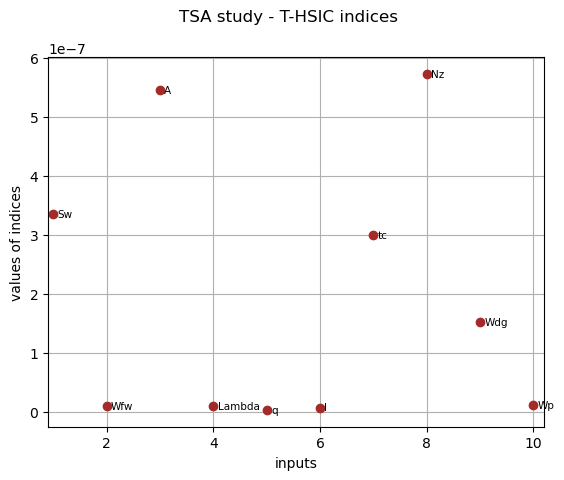

In [76]:
## Visualize T-HSIC indices
graph_TSA_HSICindices = TSAstudy.drawHSICIndices()
graph_TSA_HSICindices.setColors(["brown", "black"])
graph_TSA_HSICindices.setXTitle("inputs")
graph_TSA_HSICindices.setYTitle("values of indices")
graph_TSA_HSICindices.setTitle("TSA study - T-HSIC indices")
view = otv.View(graph_TSA_HSICindices)

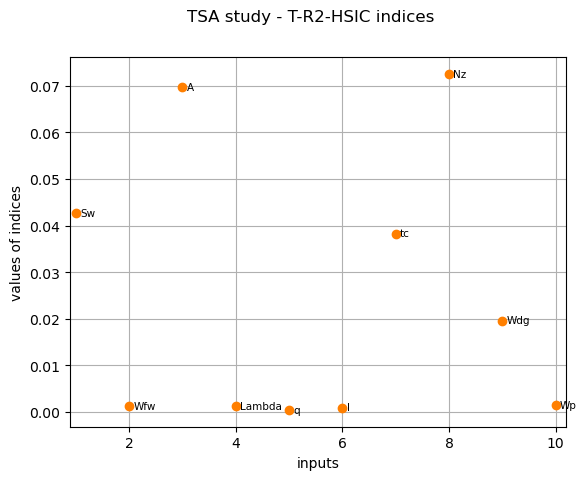

In [77]:
## Visualize T-R2-HSIC indices
graph_TSA_R2HSICIndices = TSAstudy.drawR2HSICIndices()
graph_TSA_R2HSICIndices.setColors(["darkorange1", "black"])
graph_TSA_R2HSICIndices.setXTitle("inputs")
graph_TSA_R2HSICIndices.setYTitle("values of indices")
graph_TSA_R2HSICIndices.setTitle("TSA study - T-R2-HSIC indices")
view = otv.View(graph_TSA_R2HSICIndices)

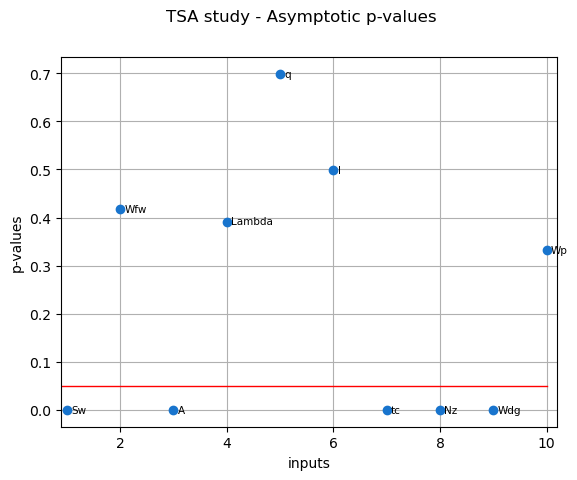

In [78]:
# Visualize asymptotic p-values
graph_TSA_pvalAsymp = TSAstudy.drawPValuesAsymptotic()
g = ot.SymbolicFunction("x","0.05") # Threshold 5%
threshold_pval = g.draw(0,d)
graph_TSA_pvalAsymp.add(threshold_pval)
graph_TSA_pvalAsymp.setColors(["dodgerblue3", "black", "red"])
graph_TSA_pvalAsymp.setXTitle("inputs")
graph_TSA_pvalAsymp.setYTitle("p-values")
graph_TSA_pvalAsymp.setTitle("TSA study - Asymptotic p-values")
view = otv.View(graph_TSA_pvalAsymp)

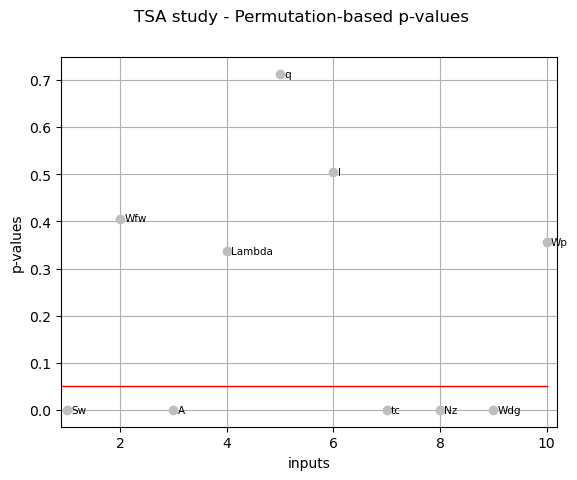

In [79]:
# Visualize permutation-based p-values
graph_TSA_pvalPerm = TSAstudy.drawPValuesPermutation()
g = ot.SymbolicFunction("x","0.05") # Threshold 5%
threshold_pval = g.draw(0,d)
graph_TSA_pvalPerm.add(threshold_pval)
graph_TSA_pvalPerm.setColors(["gray", "black", "red"])
graph_TSA_pvalPerm.setXTitle("inputs")
graph_TSA_pvalPerm.setYTitle("p-values")
graph_TSA_pvalPerm.setTitle("TSA study - Permutation-based p-values")
view = otv.View(graph_TSA_pvalPerm)

## 5 -- Performing a conditional sensitivity analysis (CSA)

Finally, we consider the **Conditional HSIC (C-HSIC) indices**. Their purpose is to characterize the influence of the input variables within a specific critical domain of the output. 

For the sake of clarity, we consider the same critical domain and the same filter function as before. 

### Running the CSA study

<span style="color:red">=> **N.B.: For CSA, we do not have an asymptotic version of the test!**</span>

In [80]:
CSAstudy = ot.HSICEstimatorConditionalSensitivity(
    covarianceModelCollection, inputDesign, outputDesign, filterFunction
)

C_HSICIndices = CSAstudy.getHSICIndices()
print("(CSA study) C-HSIC Indices:\n", C_HSICIndices)

C_R2HSICIndices = CSAstudy.getR2HSICIndices()
print("(CSA study) T-HSIC Indices:\n", C_R2HSICIndices)

C_pvalPerm = CSAstudy.getPValuesPermutation()
print("(CSA study) p-values (permutation):\n", C_pvalPerm)

(CSA study) C-HSIC Indices:
 [0.000735391,0.000240087,0.000577019,0.000154445,0.000332183,0.000313967,0.00109259,0.000791671,0.000170067,0.000936856]#10
(CSA study) T-HSIC Indices:
 [0.0346808,0.00906673,0.0344705,0.00480156,0.0106251,0.0106491,0.045125,0.0436708,0.00640903,0.0318462]#10
(CSA study) p-values (permutation):
 [0.247525,0.762376,0.39604,0.891089,0.60396,0.683168,0.138614,0.257426,0.881188,0.19802]#10


### Visualizing results

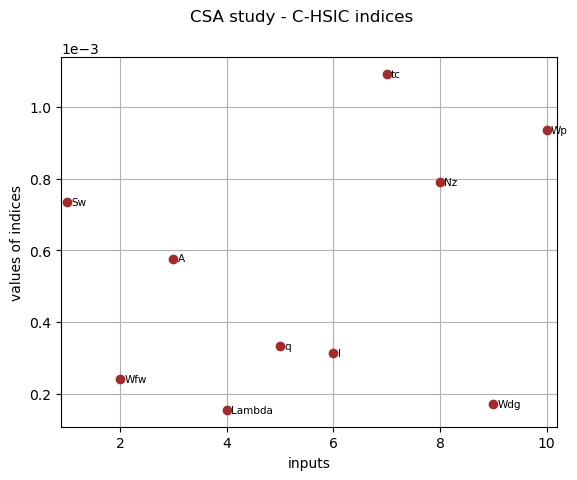

In [81]:
## Visualize C-HSIC indices
graph_CSA_HSICindices = CSAstudy.drawHSICIndices()
graph_CSA_HSICindices.setColors(["brown", "black"])
graph_CSA_HSICindices.setXTitle("inputs")
graph_CSA_HSICindices.setYTitle("values of indices")
graph_CSA_HSICindices.setTitle("CSA study - C-HSIC indices")
view = otv.View(graph_CSA_HSICindices)

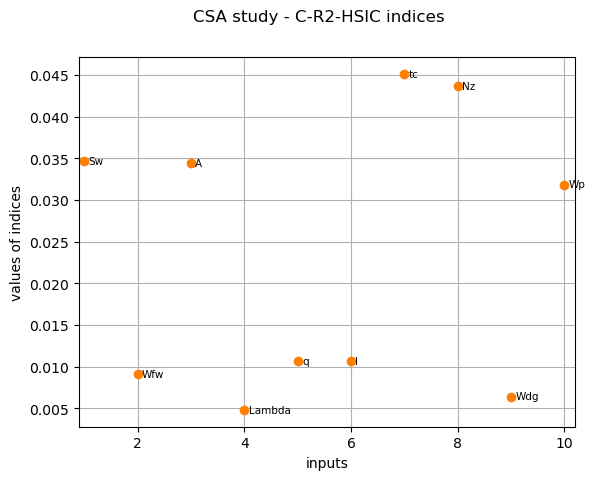

In [82]:
## Visualize C-R2-HSIC indices
graph_CSA_R2HSICIndices = CSAstudy.drawR2HSICIndices()
graph_CSA_R2HSICIndices.setColors(["darkorange1", "black"])
graph_CSA_R2HSICIndices.setXTitle("inputs")
graph_CSA_R2HSICIndices.setYTitle("values of indices")
graph_CSA_R2HSICIndices.setTitle("CSA study - C-R2-HSIC indices")
view = otv.View(graph_CSA_R2HSICIndices)

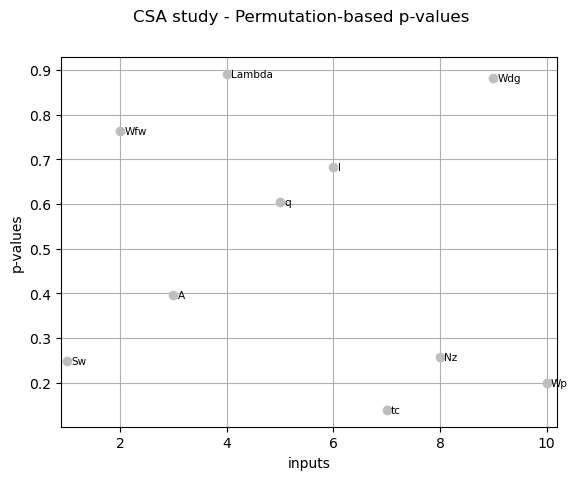

In [83]:
# Visualize permutation-based p-values
graph_CSA_pvalPerm = CSAstudy.drawPValuesPermutation()
g = ot.SymbolicFunction("x","0.05") # Threshold 5%
threshold_pval = g.draw(0,d)
graph_CSA_pvalPerm.add(threshold_pval)
graph_CSA_pvalPerm.setColors(["gray", "black", "red"])
graph_CSA_pvalPerm.setXTitle("inputs")
graph_CSA_pvalPerm.setYTitle("p-values")
graph_CSA_pvalPerm.setTitle("CSA study - Permutation-based p-values")
view = otv.View(graph_CSA_pvalPerm)

## 6 -- A brief comparison between the various analyses

### Comparing R2-HSIC indices

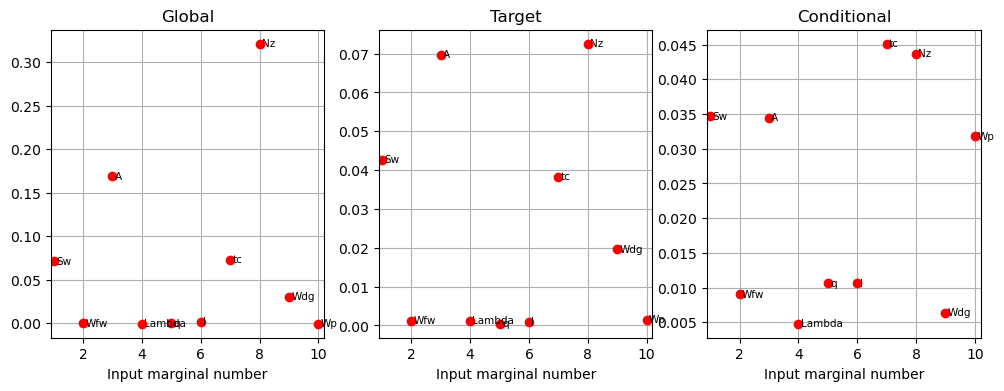

In [84]:
graph1 = GSAstudy.drawR2HSICIndices()
graph2 = TSAstudy.drawR2HSICIndices()
graph3 = CSAstudy.drawR2HSICIndices()

fig = plt.figure(figsize=(12, 4))
ghsic = fig.add_subplot(1, 3, 1)
ghsic.set_title('Global')
_ = otv.View(graph1, figure=fig, axes=[ghsic])
thsic = fig.add_subplot(1, 3, 2)
thsic.set_title('Target')
_ = otv.View(graph2, figure=fig, axes=[thsic])
chsic = fig.add_subplot(1, 3, 3)
chsic.set_title('Conditional')
_ = otv.View(graph3, figure=fig, axes=[chsic])
_ = fig.suptitle("")


### Comparing p-values

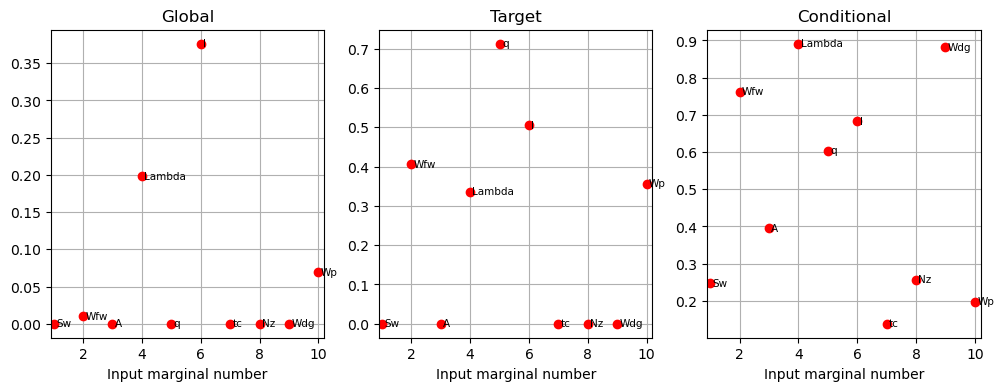

In [91]:
graph4 = GSAstudy.drawPValuesPermutation()
graph5 = TSAstudy.drawPValuesPermutation()
graph6 = CSAstudy.drawPValuesPermutation()

fig = plt.figure(figsize=(12, 4))
ghsic = fig.add_subplot(1, 3, 1)
ghsic.set_title('Global')
_ = otv.View(graph4, figure=fig, axes=[ghsic])
thsic = fig.add_subplot(1, 3, 2)
thsic.set_title('Target')
_ = otv.View(graph5, figure=fig, axes=[thsic])
chsic = fig.add_subplot(1, 3, 3)
chsic.set_title('Conditional')
_ = otv.View(graph6, figure=fig, axes=[chsic])
_ = fig.suptitle("")


## 7 -- Computing confidence intervals using the bootstrap method

Given the finite, and often small size of the samples that are used in order to compute the HSIC indices, it may be necessary to provide **confidence intervals** associated to these estimates. A possible way of doing this, is to rely on the **bootstrap** method.

In [86]:
totalSample = inputDesign
totalSample.stack(outputDesign)
experiment = ot.BootstrapExperiment(totalSample)
nboot = 10

boot_HSIC = ot.Sample(0,m.dim)
boot_R2HSIC = ot.Sample(0,m.dim)
boot_pvalAsymp = ot.Sample(0,m.dim)

for i in range(nboot):
    # We generate the bootstrap sample
    bootstrapSample = experiment.generate()
    bootstrapInput = bootstrapSample[:,:m.dim]
    bootstrapOutput = bootstrapSample[:,-1]
    
    # We compute the HSIC indices
    GSAstudy = ot.HSICEstimatorGlobalSensitivity(
        covarianceModelCollection, bootstrapInput, bootstrapOutput, estimatorType
    )
    boot_HSIC.add(GSAstudy.getHSICIndices())
    boot_R2HSIC.add(GSAstudy.getR2HSICIndices())
    boot_pvalAsymp.add(GSAstudy.getPValuesAsymptotic())

Text(0, 0.5, 'HSIC')

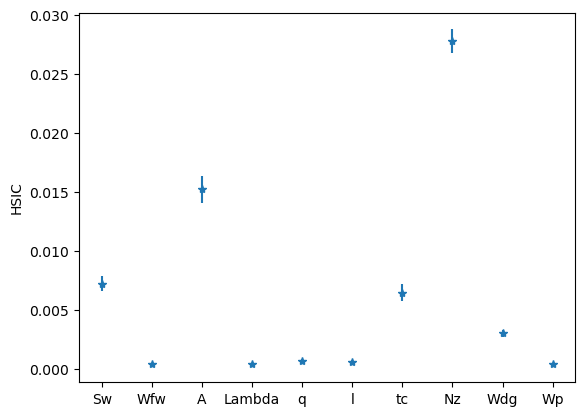

In [87]:
boot_HSIC = np.array(boot_HSIC)
plt.errorbar(np.arange(m.dim), np.mean(boot_HSIC, axis = 0), np.std(boot_HSIC, axis = 0)/2, fmt = '*')
plt.xticks(np.arange(m.dim), m.distributionX.getDescription())
plt.ylabel('HSIC')

Text(0, 0.5, 'R2 HSIC')

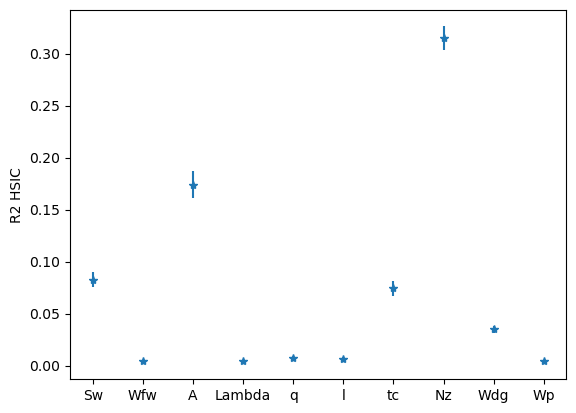

In [88]:
boot_R2HSIC = np.array(boot_R2HSIC)
plt.errorbar(np.arange(m.dim), np.mean(boot_R2HSIC, axis = 0), np.std(boot_R2HSIC, axis = 0)/2, fmt = '*')
plt.xticks(np.arange(m.dim), m.distributionX.getDescription())
plt.ylabel('R2 HSIC')

Text(0, 0.5, 'Asymptotic p-values')

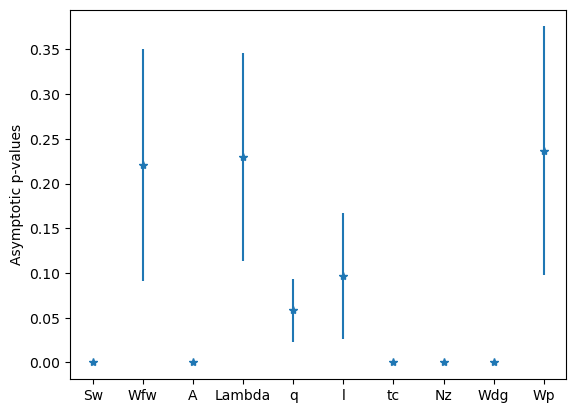

In [89]:
boot_pvalAsymp = np.array(boot_pvalAsymp)
plt.errorbar(np.arange(m.dim), np.mean(boot_pvalAsymp, axis = 0), np.std(boot_pvalAsymp, axis = 0)/2, fmt = '*')
plt.xticks(np.arange(m.dim), m.distributionX.getDescription())
plt.ylabel('Asymptotic p-values')

## 8 -- Going further

To go further about HSIC indices in OpenTURNS:

* **Another example**: http://openturns.github.io/openturns/latest/auto_reliability_sensitivity/sensitivity_analysis/plot_hsic_estimators_ishigami.html

* **About the theory**: http://openturns.github.io/openturns/latest/theory/reliability_sensitivity/sensitivity_hsic.html

A few additional analyses can be performed in order to validate the obtained results:
* What happens if you modify the number of samples? Does it make any change in the final results?
* What happens if we change the type of kernel associated to the inputs and output?
<span style="color:red">**=> Try using a Matérn-$5/2$ kernel**</span>

* What happens if we change the parametrization of the various kernels?
<span style="color:red">**=> Try different values for the scales associated to the inputs and output**</span>
* Do we obtain different results for TSA and CSA if we vary the considered threshold?
<span style="color:red">**=> Try setting the critical domain to $Y \in [400,\inf[$**</span>